In [1]:
import pickle
import numpy as np

def get_fire_stats(layer_feat_b):
    stats1 = []
    stats2 = []
    for nn in range(len(layer_feat_b)):
        stats1.append(np.mean(np.sum(layer_feat_b[nn], axis=2)))
        stats2.append(np.sum(np.sum(layer_feat_b[nn], axis=2)==0)/(layer_feat_b[nn].shape[0]*layer_feat_b[nn].shape[1]))
        
    return np.mean(stats1), np.mean(stats2)


def get_IOU(layer_feat_b1, layer_feat_b2):
    stats1 = []
    stats2 = []
    stats3 = []
    for nn in range(len(layer_feat_b1)):
        intr = np.sum(np.logical_and(layer_feat_b1[nn], layer_feat_b2[nn]))
        union = np.sum(np.logical_or(layer_feat_b1[nn], layer_feat_b2[nn]))
        stats1.append(intr/union)
        stats2.append(intr/np.sum(layer_feat_b1[nn]))
        stats3.append(intr/np.sum(layer_feat_b2[nn]))
        
    return(np.mean(stats1), np.mean(stats2), np.mean(stats3))


def get_detail(layer_feat_b1, layer_feat_b2):
    stats1 = []
    stats2 = []
    zero_cnt = 0
    single_cnt = 0
    for nn in range(len(layer_feat_b1)):
        rr, cc, vch = np.where(layer_feat_b1[nn] != layer_feat_b2[nn])
        for ri, ci in zip(rr, cc):
            stats1.append(np.sum(layer_feat_b1[nn][ri, ci]))
            stats2.append(np.sum(layer_feat_b2[nn][ri, ci]))
            if np.sum(layer_feat_b1[nn][ri, ci]) == 0:
                zero_cnt += 1
                
            if np.sum(layer_feat_b2[nn][ri, ci]) == 0:
                single_cnt += 1
            
                
    return(np.mean(stats1), np.mean(stats2), zero_cnt, single_cnt)

In [2]:
savefile = '/export/home/qliu24/VC_adv_data/cihang/adv_cls_patches/pool4FeatVC.pickle'
with open(savefile, 'rb') as fh:
    feat_set_ori, r_set_ori, feat_set_fake, r_set_fake = pickle.load(fh)
    
N = len(r_set_ori)
layer_feat_b_ori = [None for nn in range(N)]
layer_feat_b_fake = [None for nn in range(N)]
thrh4 = 0.46

stats1_ori=[]
stats2_ori=[]
stats1_fake=[]
stats2_fake=[]
for nn in range(N):
    layer_feat_b_ori[nn] = (r_set_ori[nn]<thrh4).astype(int)
    layer_feat_b_fake[nn] = (r_set_fake[nn]<thrh4).astype(int)

print(get_fire_stats(layer_feat_b_ori))
print(get_fire_stats(layer_feat_b_fake))  

print(get_IOU(layer_feat_b_ori,layer_feat_b_fake))
print(get_detail(layer_feat_b_ori,layer_feat_b_fake))
total_pixel = np.sum([np.prod(lfb.shape[0:2]) for lfb in layer_feat_b_ori])
total_diff_pixel = np.sum([np.sum(np.sum(layer_feat_b_ori[nn]!=layer_feat_b_fake[nn], axis=2)!=0) for nn in range(len(layer_feat_b_ori))])

(2.6807627184760814, 0.25347507908070288)
(2.112305417282013, 0.333511007705803)
(0.64275819143039392, 0.70089860467188692, 0.88415952217112426)
(5.1405611143904428, 2.6082069321202344, 24115, 208270)


In [3]:
import numpy as np
import pickle
import scipy.io as sio
import os

dir_anno = '/export/home/qliu24/dataset/PASCAL3D+_release1.1/Annotations/car_imagenet/'
file_list = '/export/home/qliu24/VC_adv_data/cihang/adv_cls_patches/car_test.txt'
with open(file_list, 'r') as fh:
    content = fh.readlines()
    
img_list = [x.strip().split() for x in content]
img_num = len(img_list)
print('total number of images: {0}'.format(img_num))

view_point = np.zeros(img_num)
for nn in range(img_num):
    
    file_anno = os.path.join(dir_anno, '{0}.mat'.format(img_list[nn][0]))
    assert(os.path.isfile(file_anno))
    mat_contents = sio.loadmat(file_anno)
    record = mat_contents['record']
    width_im,height_im = record['imgsize'][0][0][0][0:2]
    objects = record['objects']
    
    view_point[nn] = objects[0,0]['viewpoint'][0,int(img_list[nn][1])-1]['azimuth_coarse'][0,0][0,0]
    
print(view_point[0:10])

total number of images: 2000
[ 330.  115.  340.  185.  305.  110.  315.  145.  240.  200.]


In [7]:
file_path = '/export/home/qliu24/VC_adv_data/cihang/adv_cls_patches/'
savename = file_path + 'simmat_car_vMFMM30_mthrh046.pickle'
with open(savename, 'rb') as fh:
    mat_dis1, mat_dis2, mat_dis1_fake, mat_dis2_fake = pickle.load(fh)

180.0
180.0 180.0 180.0 180.0 180.0 .
300.0
285.0 290.0 300.0 300.0 290.0 .
330.0
325.0 325.0 325.0 325.0 325.0 .
330.0
335.0 315.0 330.0 320.0 315.0 .
270.0
275.0 270.0 270.0 270.0 270.0 .
70.0
75.0 70.0 75.0 75.0 75.0 .
45.0
30.0 45.0 30.0 60.0 35.0 .
340.0
330.0 340.0 330.0 340.0 340.0 .
65.0
75.0 75.0 60.0 230.0 55.0 .
345.0
170.0 345.0 345.0 340.0 350.0 .


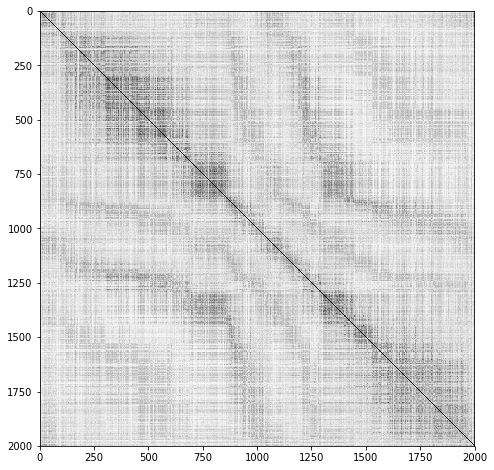

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

mat_dis = mat_dis1
mat_full = mat_dis + mat_dis.T - np.ones((N,N))
np.fill_diagonal(mat_full, 0)

idx_s = np.argsort(view_point)
gridix = np.ix_(idx_s,idx_s)
plt.imshow(mat_full[gridix])

for rr in np.random.randint(img_num,size=10):
    ref = rr
    print(view_point[ref])
    dis_rst = mat_full[rr]
    min_idx = np.argsort(dis_rst)
    for tt in range(1,6):
        match = min_idx[tt]
        print(view_point[match], end=' ')
        
    print('.')

340.0
335.0 325.0 340.0 335.0 330.0 .
340.0
340.0 340.0 340.0 340.0 340.0 .
5.0
0.0 5.0 10.0 10.0 10.0 .
90.0
90.0 90.0 90.0 105.0 90.0 .
310.0
305.0 315.0 290.0 320.0 315.0 .
10.0
20.0 20.0 20.0 25.0 25.0 .
5.0
10.0 5.0 0.0 20.0 10.0 .
55.0
55.0 75.0 55.0 60.0 60.0 .
200.0
210.0 190.0 200.0 195.0 190.0 .
25.0
20.0 55.0 30.0 35.0 30.0 .


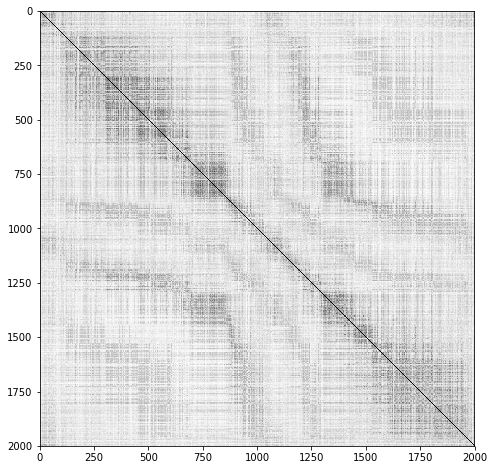

In [15]:
mat_dis = mat_dis1_fake
mat_full = mat_dis + mat_dis.T - np.ones((N,N))
np.fill_diagonal(mat_full, 0)

idx_s = np.argsort(view_point)
gridix = np.ix_(idx_s,idx_s)
plt.imshow(mat_full[gridix])

for rr in np.random.randint(img_num,size=10):
    ref = rr
    print(view_point[ref])
    dis_rst = mat_full[rr]
    min_idx = np.argsort(dis_rst)
    for tt in range(1,6):
        match = min_idx[tt]
        print(view_point[match], end=' ')
        
    print('.')

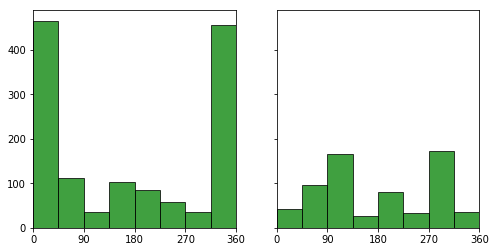

0.159688077558 0.0962306004547
0.190912215506 0.103354227263


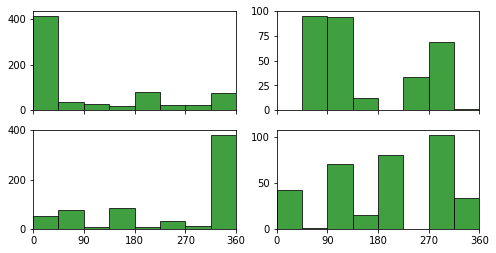

In [16]:
from sklearn.cluster import SpectralClustering
W_mat = 1. - mat_full
K = 2
cls_solver = SpectralClustering(n_clusters=K,affinity='precomputed', random_state=666)
lb = cls_solver.fit_predict(W_mat)

f, axes = plt.subplots(1,K, sharex=True, sharey=True, figsize=(8,4))
axes[0].set_xlim([0,360])
axes[0].set_xticks([0,90,180,270,360])

for k in range(K):
    axes[k].hist(np.array(view_point)[lb==k], bins=8, range=[0,360], facecolor='green', alpha=0.75,edgecolor='k')

plt.show()

idx2 = []
W_mat2 = []
lb2 = []
for k in range(K):
    idx2.append(np.where(lb==k)[0])
    W_mat2.append(W_mat[np.ix_(idx2[k],idx2[k])])
    print(np.mean(W_mat2[k]), np.std(W_mat2[k]))
    
    cls_solver = SpectralClustering(n_clusters=2,affinity='precomputed', random_state=999)
    lb2.append(cls_solver.fit_predict(W_mat2[k]))
    
K2=2
f, axes = plt.subplots(2,K, sharex=True, sharey=False, figsize=(8,4))
axes[0][0].set_xlim([0,360])
axes[0][0].set_xticks([0,90,180,270,360])
for k in range(K2*K):
    a = k//2
    b = k%2
    axes[b][a].hist(np.array(view_point)[idx2[a]][lb2[a]==b], bins=8, range=[0,360], facecolor='green', alpha=0.75, edgecolor='k')

plt.show()